# What are the factors that influence house prices in Ames, Iowa?

In this project, we will pretend that we are working in the city council of Ames, Iowa and we are planing to build multiple new constructions, for example, new roads, new parks, new hospitals, in the city in the next 5 years. For this purpose, we want to understand what the factors behind the house prices are so that we can create a fair reimbursement plan for the families that will need to relocate to give place for the new constructions. To this end, we look at a dataset about the house prices in Ames and will use it to understand as well as to predict house prices. To be specific, we would like to answer the following questions.

1. Can we predict the house prices in Ames?
2. If yes, how well can we predict the house price?
3. Other than prediction, what are the factors that most influence house prices in Ames?

## Dataset Description

The dataset that we chose to analyze in this project contains information about housing sales in Ames, IA, from 2006 to 2010. The dataset is released by Iowa's Assessor Office. It has 2,930 observations of 82 variables. The dataset and its documentation are available [online](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627).

## Data Preprocessing

We first take a look at the first few rows of the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

housing = pd.read_csv("AmesHousing.txt",sep='\t')
housing.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


Wow! We see that we have 82 features. It will take a lot of time to interprete all of them and using all features may well overfit our predicting model. Thus, to make analysis easier, we will try to select only 9 variables out of the original 82 variables. We would like to predict the values in the column `SalePrice`. We select the other eight variables which we think will be good predictors for `SalePrice`. Those eight variables are:
- Total square feet of basement area ( `Total.Bsmt.SF`)
- Above grade (ground) living area in square feet (`Gr.Liv.Area`)
- Size of garage in car capacity ( `Garage.Cars` )
- Lot size in square feet ( `Lot.Area` )
- Condition of sale (e..g., normal, foreclosure, sales between family members) (
`Sale.Condition` )
- Overall condition of the house (from 1 (very poor) to 10(excellent))
( `Overall.Cond` )
- Neighborhood of the houses inside Ames ( `Neighborhood` )
- Number of years from when the houses were last remodeled to the year of sold
( `Year.Since.Remod` )

We create a new dataframe using only 9 selected columns, eight of which will be used as features in our predictive model. 

In [2]:
housing.columns = housing.columns.str.replace(' ','.')
col_list = ['Total.Bsmt.SF','Gr.Liv.Area','Garage.Cars','Lot.Area','Sale.Condition','Overall.Cond','Neighborhood','SalePrice']
housing_subset = housing[col_list]
housing_subset['Year.Since.Remod'] = housing['Yr.Sold'] - housing['Year.Remod/Add']

C:\Users\minhn\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


According to the [paper](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627) of this dataset, houses whose areas are larger than 1500 square feet have a large variance in `SalePrice`. This is not surprising since very big houses are not common. As a result, their prices vary differently from common smaller houses. Therefore, in order to identify the factors behind house prices and to keep the assumption of homogeneous variance, which we will need later in the regression analysis, we keep only sale records of houses whose areas are less than 1500 square feet.

In [3]:
housing_equal_variance = housing_subset.loc[housing_subset['Gr.Liv.Area']<1501]
housing_equal_variance.shape

(1623, 9)

We then check for null values. Fortunately, there is only 1 rows with missing total basement value out of 1,623 observations that we have. Since the portion of missing values is almost negligible given the number of observations that we have, we simply delete this row. 

In [4]:
housing_equal_variance.isnull().sum()

Total.Bsmt.SF       1
Gr.Liv.Area         0
Garage.Cars         0
Lot.Area            0
Sale.Condition      0
Overall.Cond        0
Neighborhood        0
SalePrice           0
Year.Since.Remod    0
dtype: int64

In [5]:
housing_clean = housing_equal_variance.dropna()

housing_clean.shape

(1622, 9)

We now separate the numeric and non-numeric columns. We will create dummies variables in place of the categorical variables and look for possible correlation among the numeric variables.

In [6]:
housing_clean.dtypes

Total.Bsmt.SF       float64
Gr.Liv.Area           int64
Garage.Cars         float64
Lot.Area              int64
Sale.Condition       object
Overall.Cond          int64
Neighborhood         object
SalePrice             int64
Year.Since.Remod      int64
dtype: object

In [7]:
numeric_cols = housing_clean.drop('SalePrice',axis=1).select_dtypes(include=['float64','int64']).columns
cat_cols = housing_clean.select_dtypes(include=['object']).columns

df = housing_clean.drop('SalePrice',axis=1).copy()
for col in cat_cols:
    df = pd.concat([df.drop(col,axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep = "_", drop_first = True)],axis=1)

df.head()

,Total.Bsmt.SF,Gr.Liv.Area,Garage.Cars,Lot.Area,Overall.Cond,Year.Since.Remod,Sale.Condition_AdjLand,Sale.Condition_Alloca,Sale.Condition_Family,Sale.Condition_Normal,...,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
1,882.0,896,1.0,11622,6,49,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1329.0,1329,1.0,14267,6,52,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,1338.0,1338,2.0,4920,5,9,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
7,1280.0,1280,2.0,5005,5,18,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
11,1168.0,1187,2.0,7980,7,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Exploratory Analysis

We plot the scatterplot matrix of all the numeric variables to look for signs of collinearity.

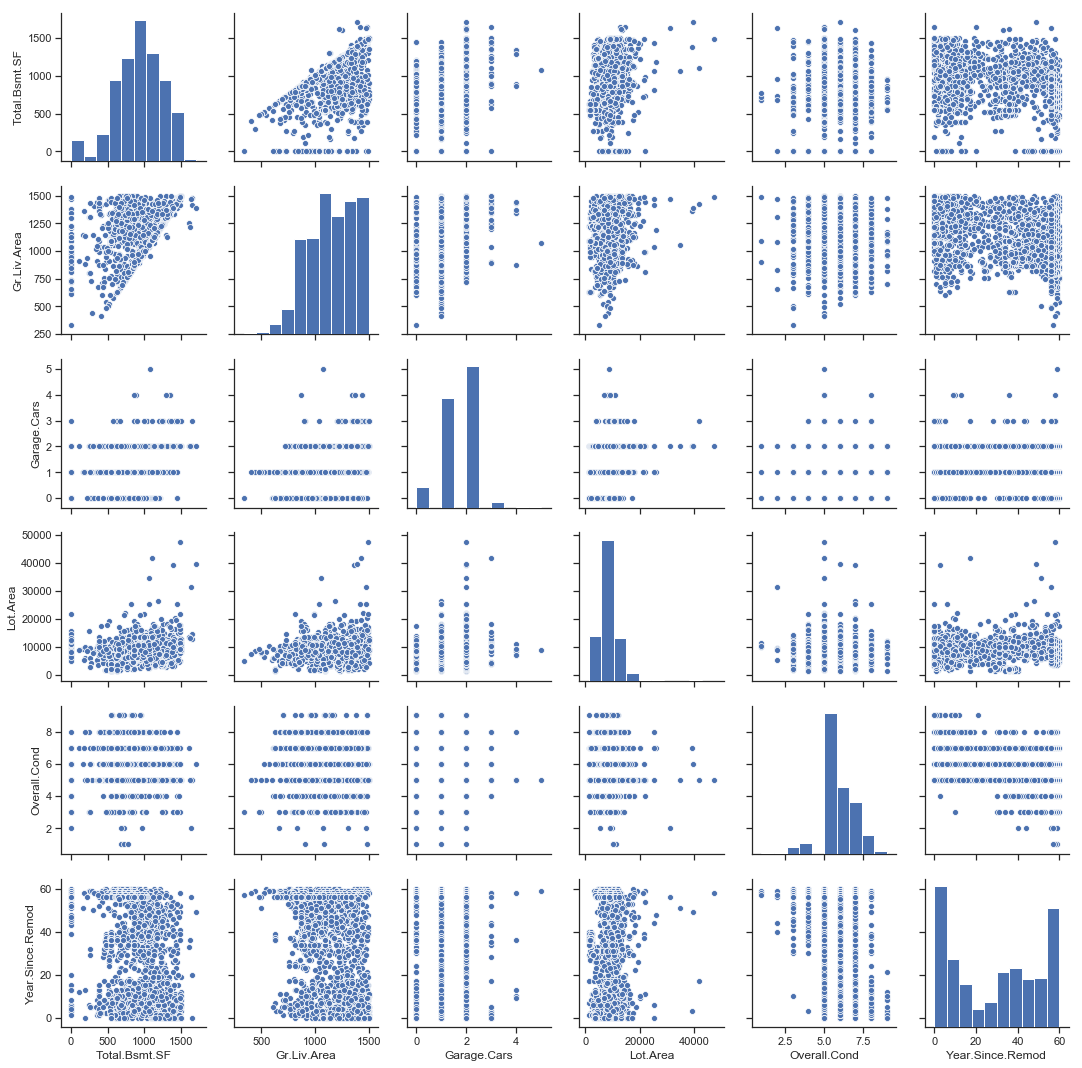

In [8]:
import seaborn as sns
sns.set(style="ticks")

sns.pairplot(housing_clean[numeric_cols])

Looking at the diagonal histogram plots, we see that no variables is extremeley skewed or contains extreme outliers. In addition, we observe that no pairs of variables has a high correlation. We verify this with a correlation matrix.

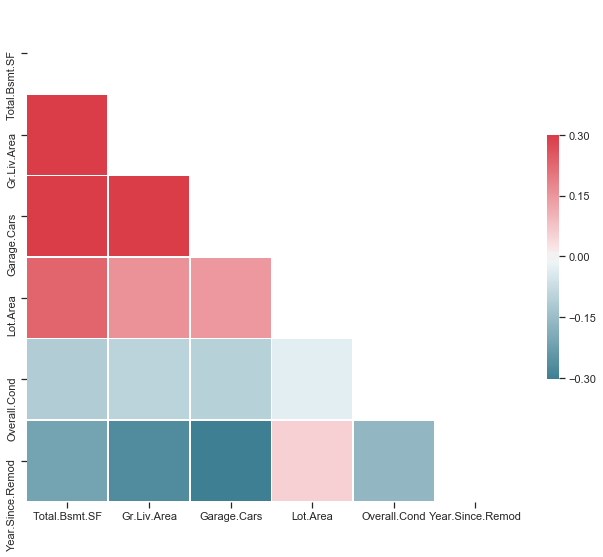

In [9]:
corr = df[numeric_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We see that no pairs of variables are closely correlated. This is a good sign for us to since one of the most common models, i.e., the linear regression model, assumes that the variables are uncorrelated.

## Modeling

Before building the model, we separate the data into training set and testing set.

In [10]:
X = df
y = housing_clean['SalePrice']

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing
from math import sqrt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=20)

We will try two types of model to predict the house price: k-nearest neighbors and linear regression.

### K-Nearest Neighbors

In [11]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=5, leaf_size = 30)

X_train_scaled = preprocessing.scale(X_train)
X_test_scaled = preprocessing.scale(X_test)

neigh.fit(X_train_scaled, y_train)

#Predict using your model
y_test_preds = neigh.predict(X_test_scaled)
y_train_preds = neigh.predict(X_train_scaled)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
rmse_test_score = sqrt(mean_squared_error(y_test, y_test_preds))
rmse_train_score = sqrt(mean_squared_error(y_train, y_train_preds))

print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))
print("The RMSE on the training data was {}.  The RMSE on the test data was {}.".format(rmse_train_score, rmse_test_score))

The rsquared on the training data was 0.8087835506158656.  The rsquared on the test data was 0.7419736802369556.
The RMSE on the training data was 17215.309634821166.  The RMSE on the test data was 20256.916198760708.


C:\Users\minhn\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  """
C:\Users\minhn\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  


We observe that using k-nearest neighbors, the R-squared we obtain is only 0.74. Let's see if we can do better using linear regression. We will try to build linear regression model using both scikit-learn and statsmodels libraries.

### Linear Regression Model using Scikit-learn

Scikit-learn is a popular library for machine learning model. We will first try linear regression using scikit-learn.

In [12]:
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
rmse_test_score = sqrt(mean_squared_error(y_test, y_test_preds))
rmse_train_score = sqrt(mean_squared_error(y_train, y_train_preds))

print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))
print("The RMSE on the training data was {}.  The RMSE on the test data was {}.".format(rmse_train_score, rmse_test_score))

The rsquared on the training data was 0.793576467061616.  The rsquared on the test data was 0.7956829597198809.
The RMSE on the training data was 17886.765645476116.  The RMSE on the test data was 18025.761551301544.


We see that using only 8 variables, we are able to capture about 79.6% of the variance in the data. Moreover, the R-squared score is almost the same for the test dataset, indicating that our model generalizes well to data it has never seen before. The RMSE score indicates that we make an error of about $18,000 on predicting house prices. 

In [13]:
import numpy as np

def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(40)

,est_int,coefs,abs_coefs
20,Neighborhood_GrnHill,105187.898642,105187.898642
21,Neighborhood_IDOTRR,-35776.834774,35776.834774
19,Neighborhood_Greens,35549.370685,35549.370685
29,Neighborhood_OldTown,-33905.348927,33905.348927
23,Neighborhood_MeadowV,-32166.522997,32166.522997
34,Neighborhood_StoneBr,30228.691097,30228.691097
13,Neighborhood_BrkSide,-26801.679281,26801.679281
28,Neighborhood_NridgHt,25923.626846,25923.626846
17,Neighborhood_Edwards,-25747.358562,25747.358562
12,Neighborhood_BrDale,-24429.527909,24429.527909


Looking at the coefficient weights, we can clearly see that neighborhood is the most important factor that influences house price in Ames. For instance, houses in Green Hills, Greens, and Stone Brook tend to have high prices, whereas houses in Iowa DOT and Rail Road, Old Town, and Meadow Village tend to have lower prices. 

Also, the sale condition also affects sale price. Houses were sold between family members with lower price than the market. While adjoining land purchases and new houses often increase the price. 

Next, the coefficient weights suggest that houses with large garage capacity or high overal condition were traded at higher prices. This finding is enforced by the negative coefficient of the number of years after remodelling. The fewer number of years, or in other words, the newer the house, the higher price it has. 

Next, we will look at the residual plots to see if this linear model is a good fit to the data.

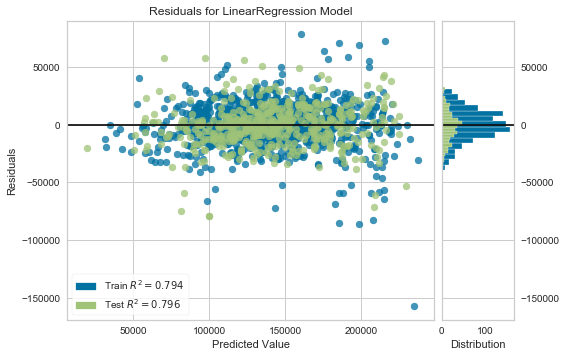

In [14]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

We see that the residuals disperse randomly throughout the predicted values, indicating that using linear model is appropriate. Furthermore, the histogram of the residual also roughly resembles the Gaussian shape, signifying that the residuals are Normally distributed.

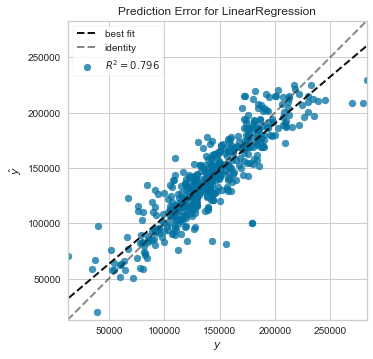

In [15]:
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(LinearRegression())

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()    

Looking at the above plot, we see that there are not too much variance in our data. The fitted line is close to the reference diagonal line. This means that our predicted house price is quite close to the real price.

### Linear Regression Using statsmodels

While scikit-learn is well-known to the machine learning community, statsmodels is favored by the statistics community due to its support for statistical tools and tests. We will hereby try building linear regression model using statsmodels library.

In [16]:
import statsmodels.formula.api as sm

stat_model = sm.OLS(y_train, X_train)
stat_model_fit = stat_model.fit()

print(stat_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1916.
Date:                Fri, 14 Feb 2020   Prob (F-statistic):               0.00
Time:                        11:32:41   Log-Likelihood:                -12726.
No. Observations:                1135   AIC:                         2.553e+04
Df Residuals:                    1098   BIC:                         2.571e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Total.Bsmt.SF             34

Looking at the p-values, we see that all of our regressors are significant. 

In [17]:
#Predict using your model
y_test_preds = stat_model_fit.predict(X_test)
y_train_preds = stat_model_fit.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
rmse_test_score = sqrt(mean_squared_error(y_test, y_test_preds))
rmse_train_score = sqrt(mean_squared_error(y_train, y_train_preds))

print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))
print("The RMSE on the training data was {}.  The RMSE on the test data was {}.".format(rmse_train_score, rmse_test_score))

The rsquared on the training data was 0.7929618043296148.  The rsquared on the test data was 0.7925557491350095.
The RMSE on the training data was 17913.3763614475.  The RMSE on the test data was 18163.18594506708.


The prediction result is a little bit worse than that of the scikit-learn model. However, the difference is not big. Let's look at the residual plots pf this model. 

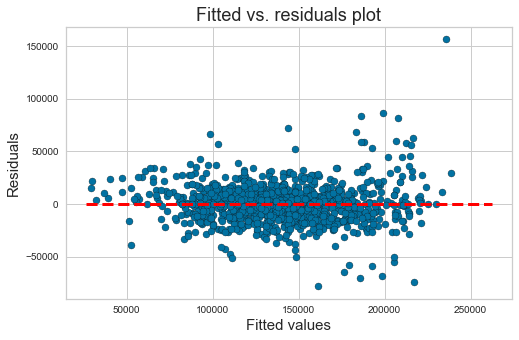

In [18]:
plt.figure(figsize=(8,5))
p=plt.scatter(x=stat_model_fit.fittedvalues,y=stat_model_fit.resid,edgecolor='k')
xmin=min(stat_model_fit.fittedvalues)
xmax = max(stat_model_fit.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

We observe that the red line is almost horizontal which means the residuals have equal variance throughout the fitted values.

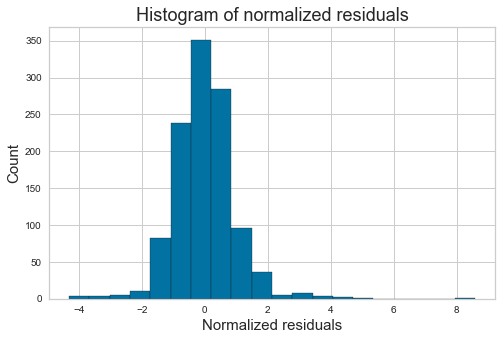

In [19]:
plt.figure(figsize=(8,5))
plt.hist(stat_model_fit.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

We can also tell that the residuals are about symmetric and centered at 0, roughly follows a normal distribution.

<Figure size 576x360 with 0 Axes>

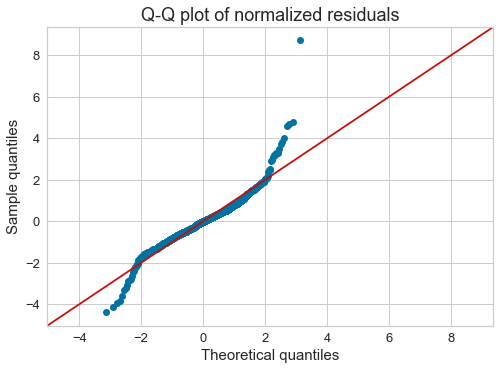

In [20]:
from statsmodels.graphics.gofplots import qqplot

plt.figure(figsize=(8,5))
fig=qqplot(stat_model_fit.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

In the Normal Q-Q plot, apart from a small amount of data points show deviation at both tails, most of the data points fall on the straight line, which means the normality assumption of the residuals holds.

In [21]:
from scipy.stats import shapiro

_,p=shapiro(stat_model_fit.resid)

if p<0.01:
    print("The residuals seem to come from Gaussian process")
else:
    print("The normality assumption may not hold")

The residuals seem to come from Gaussian process


Finally, we perform the Shapiro-Wilk test to verify that the residual indeed follows a Normal distribution. Combining information from all the residual plots, we can conclude that our linear model is appropriate and well fitted to the data.

## Conclusion

Through this project, we have seen that we can predict the house price in Ames with an estimated error of $18,000 using only 8 variables from the Ames housing dataset. We also see that the factors that vary most with the house price are neighborhood, sale condition, garage size, condition and size of the house. This project may provide useful insight on assessing the house price for the reimbursement plan in Ames.   